# Pregunta SVM

SVM es un modelo de machine learning utilizado para clasificar, el cual consiste básicamente en encontrar el mejor hiperplano separador de los datos (aquel que maximiza el margen de los vectores de soporte), es decir, no es más (ni menos) que un problema de optimización. Como se ha visto en clases, una de las formas para resolver este problema es a partir de las condiciones de Karush-Kuhn-Tucker (KKT), pero también existen otros métodos de hacerlo, como lo es la técnica de **descenso de gradiente**. Con el descenso de gradiente se busca iterativamente actualizar los parámetros que determinan el hiperplano separador al moverse en la *dirección del gradiente* de la función que queremos maximizar (o minimizar). Esto es:

$$\vec{w}^{(t+1)} = \vec{w}^{(t)} - \mu \cdot \nabla c(\vec{w}^{(t)})$$

Donde $\mu$ es sólo un escalar que determina el tamaño de los pasos en que avanzamos en dirección al gradiente (learning rate), mientras que la función que queremos minimizar (función de costo) es la siguiente:

$$c(w) =  \frac{1}{2}||\vec{w}||^2 + C*\sum \limits_{i=1}^{n}(1-y_i*<\vec{x_i},\vec{w}>)$$

Y al derivar $c(\vec{w})$ con respecto a $\vec{w}$:

$$\nabla c(\vec{w}) = \vec{w} - C\sum \limits_{i=1}^{n} y_i \cdot \vec{x_i} $$

Dicho esto, se propone una implementación de un modelo de SVM construido desde cero. Es decir, no ocuparemos las funcionalidades que nos provee *sklearn* sino que sólo *numpy*.

In [1]:
!pip -q install celluloid
# Creamos el dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from celluloid import Camera
from IPython.core.display import Video
import celluloid


# Definimos una clase con la implementación de SVM binario
class BinaryClassifierSVM:
    
    # El modelo tiene por defecto el valor de los parametros del hiperplano y C.
    def __init__(self, C=1):
        self.C = C
        self.params = np.array([-1, 1, 1]).astype(float)
    
    # Esta función retornará cuán mal se ajusta nuestra hipótesis actual a los datos
    def funcion_costo(self, X, Y):
        norm = (self.params**2).sum()        # 1. Norma de los parámetros (||B||)
        dist = 1 - Y*np.dot(X,self.params)   # 2. A cuánto estamos actualmente dentro del margen máximo para cada punto!
        dist = dist[dist>0]             # Sólo nos importa las distancias que son mayores a cero,
                                        # porque eso podría significar:
                                        # a) Esta bien clasificada, pero el margen es menor a 1 --> (0 < 1 - Y * <X,w> < 1).
                                        # b) Esta mal clasificado (Y*<x, w> < 0)
        return norm/2, self.C*dist.sum(), norm/2+self.C*dist.sum()
    
    # Esta función calcula el gradiente de nuestra función de costo con respecto a 
    # nuestros parámetros
    def calcular_gradiente(self, X, Y):
        grad_margin = self.params
        dist = 1 - Y*np.dot(X,self.params) # Calculamos la distacia entre los puntos y e hiperplano
        valid_sample = (dist>0).astype(float) # Sólo consideramos los datos que están dentro del margen o mal clasificados
        valid_sample = np.expand_dims(valid_sample,axis=1).repeat(3,axis=1)
        Y = np.expand_dims(Y,axis=1).repeat(3,axis=1)
        grad_clas = -valid_sample*Y*X 

        return grad_margin+self.C*grad_clas.sum(axis=0) # Retornamos el gradiente como la fórmula de arriba
    
    def train(self, X_train, y_train):
        iterations = 50         # Número de iteraciones que tomaremos
        delta = 0.005           # Tamaño de los pasos para cada iteración del Descenso de Gradiente
        
        # Sólo para visualización!! Condiciones iniciales
        self.hyperplane_plot(X_train, y_train, 0, init_conditions=True)
        ##############################################
        
        # Train our SVM
        for iteration in range(1,iterations+1):

            # Calculamos el gradiente!
            grad = self.calcular_gradiente(X_train, y_train)
            # paso en Descenso de Gradiente!
            self.params -= delta*grad
            # Actualizamos desempeño de métricas
            norma, dist, total = self.funcion_costo(X_train, y_train)

            # Sólo para visualización!! Nuevo hiperplano
            self.hyperplane_plot(X_train, y_train, iteration)
        # Creamos animación final
        self.generate_animation()
        
    # Sólo para visualización
    def hyperplane_plot(self, X_train, y_train, iteration, init_conditions=False):
        if init_conditions:
            self.x_line = np.arange(-3,5,0.1)
            fig, self.ax = plt.subplots()
            self.ax.set_ylim([-7, 7])
            self.camera = Camera(fig)
        size = len(X_train) // 2
        line = [-(self.params[-1] + x*self.params[0])/self.params[1] for x in self.x_line]
        self.ax.text(0.5, 1.01, f"Iteración: {iteration} - Costo :{self.funcion_costo(X_train, y_train)[-1]:.2f}", transform=self.ax.transAxes)
        plt.scatter([x[0] for x in X_train[:size]],[x[1] for x in X_train[:size]],color="red")
        plt.scatter([x[0] for x in X_train[size:]],[x[1] for x in X_train[size:]],color="blue")
        plt.plot(self.x_line, line, color = "green")
        self.camera.snap()
    
    # Sólo para visualización
    def generate_animation(self):
        anim = self.camera.animate(blit=True)
        writergif = animation.PillowWriter(fps=30)
        anim.save('result.gif',writer=writergif)
        Video("result.gif", embed=True)
    
    def accuracy(self, X_test, y_test):
        # Calculamos predicciones para nuestro modelo
        preds = np.dot(X_test, self.params) > 0 # Calculamos distancia para cada dato y verificamos su clasificación
        correct = preds == (np.array(y_test) > 0) # Sólo tomamos los datos bien clasificados
        accuracy = correct.astype(int).sum()/correct.shape[0]  
        return 100 * accuracy

You should consider upgrading via the 'c:\users\fopas\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


Para poner a prueba el modelo creado generaremos un set de datos que sea casi linealmente separable.

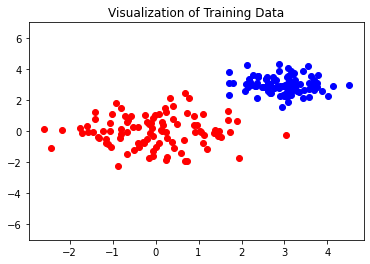

In [2]:
# Simple code to generate the data
# Simple código para generar los datos

size = 100
train_data = []
test_data = []
labels = [-1 for i in range(size)] # Clase negativa
labels += [1 for i in range(size)] # Clase positiva

# Queremos predecir puntos tomados de una distribución normal
mu = [[0,0], [3.0,3.0]]                  # Medias
std = [[[1,0],[0,1]],[[1/3,0], [0,1/3]]] # Matriz de covarianza

# Creamos el set de train
for i in range(len(mu)):
    train_data += list(np.random.multivariate_normal(mu[i],std[i],size))

train_data = np.array(train_data)
train_data = np.c_[ train_data, np.ones(2*size) ]

# Creamos el set de test
for i in range(len(mu)):
    test_data += list(np.random.multivariate_normal(mu[i],std[i],size))

test_data = np.array(test_data)
test_data = np.c_[ test_data, np.ones(2*size) ]

# Graficamos!
# Graficamos condiciones iniciales!
fig, ax = plt.subplots()
ax.set_ylim([-7, 7])
plt.title("Visualization of Training Data")
plt.scatter([x[0] for x in train_data[:size]],[x[1] for x in train_data[:size]],color="red")
plt.scatter([x[0] for x in train_data[size:]],[x[1] for x in train_data[size:]],color="blue")
plt.show()

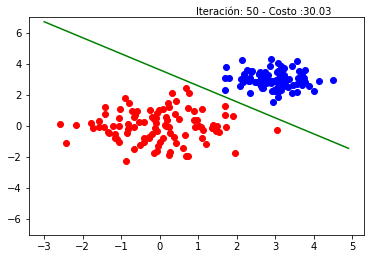

In [3]:
# Instanciamos nuestro modelo con los datos generados
SVM_binary_classifier = BinaryClassifierSVM(C=10)

# Entrenamos el modelo..
SVM_binary_classifier.train(train_data, labels)

Training Accuracy: 100.0%
Test Accuracy: 99.0%


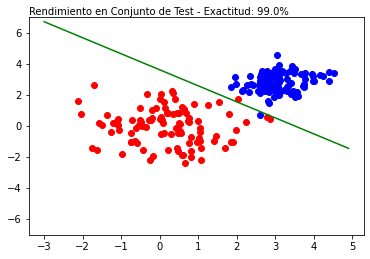

In [4]:
# Accuracy para train y test.
train_accuracy = SVM_binary_classifier.accuracy(train_data, labels)
print(f"Training Accuracy: {train_accuracy}%")

test_accuracy = SVM_binary_classifier.accuracy(test_data, labels)
print(f"Test Accuracy: {test_accuracy}%")

# Visualización del hiperplano en el set de test
x_line = np.arange(-3,5,0.1)
line = [-(SVM_binary_classifier.params[-1] + x*SVM_binary_classifier.params[0])/SVM_binary_classifier.params[1] for x in x_line]
fig, ax = plt.subplots()
ax.text(0.0, 1.01, f"Rendimiento en Conjunto de Test - Exactitud: {test_accuracy}%", transform=ax.transAxes)
ax.set_ylim([-7, 7])
plt.scatter([x[0] for x in test_data[:size]],[x[1] for x in test_data[:size]],color="red")
plt.scatter([x[0] for x in test_data[size:]],[x[1] for x in test_data[size:]],color="blue")
plt.plot(x_line, line, color = "green")
plt.show()

# Pregunta 1

Según lo visto en clases y lo expuesto en el ejemplo se aprecia que SVM corresponde a un **clasificador binario**, sin embargo, uno podría querer clasificar más de una clase. Explica con tus propias palabras cómo se podría modificar el modelo que tenemos para transformarlo en un **clasificador multiclase**.

# Pregunta 2

Modifica el modelo propuesto a modo de transformarlo en un clasificador multiclase. Puedes probar su funcionamiento con el dataset entregado en la última celda.

También grafica la superficie de decisión de tu SVM utilizando la función *plot_decision_surface* del código base.

In [5]:
class MulticlassClassifierSVM:
    
    # Del mismo modo que la implementación anterior agrego detalles por defecto que tendrá el modelo
    def __init__(self, size=100, C=1, n_classes=3):
        self.C = C
        self.n_classes = n_classes
        self.size = size # Cantidad de datos por cada clase
        # Tendré que generar n planos si tengo n clases
        self.params = np.random.rand(n_classes, 3)
    
    # Esta función retornará cuán mal se ajusta nuestra hipótesis actual a los datos
    def costo_multiclase(self, X, Y):
        # FUNCIÓN A IMPLEMENTAR
        norm = (self.params**2).sum()        # 1. Norma de los parámetros (||B||)
        dist = np.zeros_like(Y[:self.size]).astype(float)

        for cur_class in range(self.n_classes):
            cur_data = X[cur_class*size:(cur_class+1)*self.size]
            for comp_class in range(self.n_classes):
                if cur_class != comp_class:
                    cur_dist = 1 - np.dot(cur_data,self.params[cur_class]) + np.dot(cur_data,self.params[comp_class]) # Relative Margin
                    cur_dist[cur_dist<0] = 0
                    dist += cur_dist 
        # Sólo nos interesan los margenes relativos que son mayores a 0,
        # Porque estos son o:
        # a) Los que están bien clasificados pero su margen es menor a 1 --> (0 < 1 - Y * <X,w> < 1).
        # b) Los que están incorrectamente clasificados (Y*<x, w> < 0)
        return norm/2, self.C*dist.sum(), norm/2+self.C*dist.sum()
    
    # Esta función calcula el gradiente de nuestra función de costo con respecto a 
    # nuestros parámetros
    def gradiente_multiclase(self, X, Y):
        # FUNCIÓN A IMPLEMENTAR
        grad_margin = self.params

        dist = np.zeros_like(Y).astype(float)
        grad_class = np.zeros_like(self.params)

        for cur_class in range(self.n_classes):
            cur_data = X[cur_class*self.size:(cur_class+1)*self.size]
            for comp_class in range(self.n_classes):
                if cur_class != comp_class:
                    cur_dist = 1 - np.dot(cur_data, self.params[cur_class])+ np.dot(cur_data,self.params[comp_class]) # Relative Margin
                    valid_sample = (cur_dist>0).astype(float)
                    valid_sample = np.expand_dims(valid_sample,axis=1).repeat(3,axis=1)
                    grad_class[cur_class] += -(valid_sample*cur_data).sum(axis=0)
                    grad_class[comp_class] += +(valid_sample*cur_data).sum(axis=0)

        return grad_margin+self.C*grad_class/(self.n_classes*self.size)
    
    def train(self, X_train, y_train):
        # FUNCIÓN A IMPLEMENTAR
        iterations = 200         # Número de iteraciones que haremos
        delta = 0.005           # Tamaño de los pasos para cada iteración del Descenso de Gradiente
        
        # Entrenamos el SVM con el nuevo y_train
        for iteration in range(1,iterations+1):

            # Calculate gradient!
            grad = self.gradiente_multiclase(X_train, y_train)
            # Gradient Descent step!
            self.params -= delta*grad
            # Get updated performance metrics
            norma, dist, total = self.costo_multiclase(X_train, y_train)
            
            # print(f"Iteracion: {iteration} - Costo {total:.2f}, Norma: {norma:.2f}, Dist: {dist:.2f} ")
            
    # Función retorna lista con predicciones según X_test
    def predict(self, X_test):
        preds = list()
        for t in X_test:
            maximo = 0
            max_class = -1
            for i, p in enumerate(self.params):
                val = np.dot(p,t)
                if val > maximo:
                    maximo = val
                    max_class = i
            preds.append(max_class)
        return np.array(preds)
                
    def plot_decision_surface(self, X_train, y_train):
        fig, ax = plt.subplots()
        
        x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
        y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))

        Z = self.predict(np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape[0])])
        Z = Z.reshape(xx.shape)
        out = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
        
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title('Superficie de decisión SVM Multiclase')
        ax.legend()
        plt.show()
    
    def accuracy(self, X_test, y_test):
        # FUNCIÓN A IMPLEMENTAR
        preds = list()
        for t in X_test:
            maximo = 0
            max_class = -1
            for i, p in enumerate(self.params):
                val = np.dot(p,t)
                if val > maximo:
                    maximo = val
                    max_class = i
            preds.append(max_class)
        return 100*(np.array(preds) == y_test).astype(int).sum()/len(y_test)

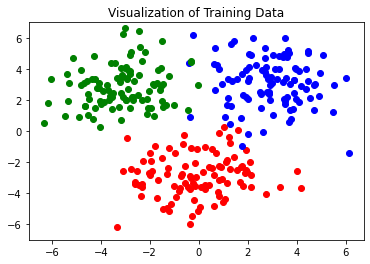

In [6]:
# Data set multiclase:
# Código para generar datos de múltiples clases

n_classes = 3
size = 100
train_data = []
test_data = []
labels = list()
for i in range(n_classes):
    labels += [i for _ in range(size)] # Generamos datos de múltiples clases (100 ejemplos por clase)

# Queremos predecir puntos tomados de una distribución normal
mu = [[0,-3.0], [3.0,3.0], [-3.0,3.0]]                 # Promedios
std = [[[2,0],[0,2]], [[2,0],[0,2]], [[2,0],[0,2]]] # Matriz de covarianza

# Creamos el set de train
for i in range(len(mu)):
    train_data += list(np.random.multivariate_normal(mu[i],std[i],size))

train_data = np.array(train_data)
train_data = np.c_[ train_data, np.ones(n_classes*size) ]

# Creamos el set de test
for i in range(len(mu)):
    test_data += list(np.random.multivariate_normal(mu[i],std[i],size))

test_data = np.array(test_data)
test_data = np.c_[ test_data, np.ones(n_classes*size) ]

# Graficamos!
# Graficamos condiciones iniciales!
fig, ax = plt.subplots()
ax.set_ylim([-7, 7])
colors = ['red','blue','green']
plt.title("Visualization of Training Data")
for i in range(n_classes):
    plt.scatter([x[0] for x in train_data[i*size:(i+1)*size]],[x[1] for x in train_data[i*size:(i+1)*size]],color=colors[i])
plt.show()


No handles with labels found to put in legend.


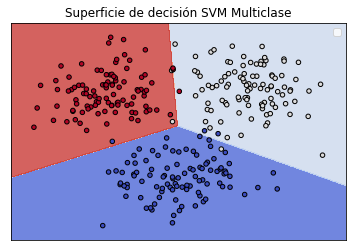

In [7]:
# Acá deberías entrenar tu modelo y graficar..
# Descomenta las siguientes lineas una vez que hayas implementado el modelo

# Instanciamos el modelo
svm_mul_classifier = MulticlassClassifierSVM(C=10)

# Entrenamos el módelo
svm_mul_classifier.train(train_data, labels)

# Graficamos superficie de decisión
svm_mul_classifier.plot_decision_surface(train_data, labels)

In [8]:
# Acá deberías probar el desempeño de tus resultados..
# Descomenta las siguientes lineas una vez que hayas implementado el modelo

# En el set de train
print(f"Train acc: {svm_mul_classifier.accuracy(train_data, labels)}%")

# En el set de test
print(f"Test acc: {svm_mul_classifier.accuracy(test_data, labels)}%")

Train acc: 97.0%
Test acc: 96.66666666666667%
